- new larger unrestricted title database
- emoji information
- stock ticker database

objectives:
- associate the title with ticker info
- find correlation between score and comments
- find posts made during events in the GME shortsqueeze and correlate with WSB activity and posts
- create custom vocabulary of WSB for improved semantic analysis
- find if post = pos/neg and plot against the current stock being refered
- new column for tickers, ticker direction
- possibly try and understand what financial instruments are being used through feature extraction (option, future, forward)
- associate findings against hedge fund research and models
- determine if theyre correct or missing a larger part of the picture
- provide an analysis of highly influential figures on WSB e.g. DeepFuckingValue


new thoughts:
- try and implement ideas that hedge funds dicuss into exploiting retail traders
- determine if theyre effective e.g. barclays paper

provide any additional thoughts as to why the events occured in the way they did and if any other recent events e.g. NVDA can be manipulated by retail investors

another great example of retail investors surprising the larger institutional investors is when the day trader in england shorted the value of oil.

*** definitely worthy expaning on this topic and braching out to look at other events when retail investors were underestimated by institutional investors

## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from datetime import datetime
import spacy as sp
from spacy.matcher import PhraseMatcher, Matcher
from collections import Counter



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



## Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')
df = df[['title', 'score', 'removed_by', 'total_awards_received',
           'created_utc', 'num_comments']]
df = df.loc[df['score'] >= np.mean(df['score'])]
df = df.reset_index(drop=True)

<ipython-input-3-df1898621b75>:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')


In [4]:
# put tickers into dataframe
cols = ['symbol', 'id']
tickers = pd.read_csv('/content/drive/MyDrive/ticker.txt', delimiter = "\t", header=None, names = cols)

In [5]:
# some tickers are the same as common words or letters such as NAN, K, AND
tickers['symbol'] = tickers['symbol'].str.upper()
tickers = tickers.dropna()

## Vader Sentiment Scores

In [6]:
# Calculate polarity scores
sia = SIA()
# baseline compound is pos if >= 0.05, neg if <= -0.05 and neu else
# change baseline to 0 for binary classification
def calculate_sentiment(text):
    pol_score = sia.polarity_scores(text)
    if pol_score['compound'] >= 0.05:
        return 1
    elif pol_score['compound'] <= -0.05:
        return -1
    else:
        return 0

In [7]:
df['sentiment'] = df.apply(lambda x: calculate_sentiment(x.title), axis=1)
df['compound'] = df.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)
df.head(3)

,title,score,removed_by,total_awards_received,created_utc,num_comments,sentiment,compound
0,Is XRT is being used to hide GME shorts?,30,deleted,0.0,1613448160,41,-1,-0.1779
1,Till Alpha Centauri 💎✋🚀🚀,41,NaN,0.0,1613448113,52,0,0.0000
2,Here’s to 2021 boys 🥂,34,NaN,4.0,1613446345,19,0,0.0000


In [8]:
# counting sentiments
sentiments = [-1, 0, 1]
sentiments_count = [sum(df.sentiment == -1), sum(df.sentiment == 0), sum(df.sentiment == 1)]
df.sentiment.value_counts()

sentiment
 0    24802
 1    13321
-1     9838
Name: count, dtype: int64

## TextBlob Sentiment Scores

In [9]:
from textblob import TextBlob

def calculate_sentiment_tb(text,compound=True):
    blob = TextBlob(text)

    if compound:
        return blob.polarity

    else:
        if blob.polarity >= 0.05:
            return 1
        elif blob.polarity <= -0.05:
            return -1
        else:
            return 0

df['tb_sentiment'] = df.apply(lambda x: calculate_sentiment_tb(x.title), axis=1)

In [10]:
df.head(3)

,title,score,removed_by,total_awards_received,created_utc,num_comments,sentiment,compound,tb_sentiment
0,Is XRT is being used to hide GME shorts?,30,deleted,0.0,1613448160,41,-1,-0.1779,0.0
1,Till Alpha Centauri 💎✋🚀🚀,41,NaN,0.0,1613448113,52,0,0.0000,0.0
2,Here’s to 2021 boys 🥂,34,NaN,4.0,1613446345,19,0,0.0000,0.0


# RoBERta semantic analysis

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [16]:
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [17]:
def predict_sentiment(text):
  inputs = tokenizer(text, return_tensors="pt", max_length=1022, truncation=True)
  outputs = model(**inputs)
  sentiment_class = outputs.logits.argmax(dim=1).item()
  sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
  predicted_sentiment = sentiment_mapping.get(sentiment_class, 'Unknown')
  return predicted_sentiment

In [19]:
# this next takes > 5 minutes to run, do it for each of the 5.5 sections of 5000 entries

In [20]:
first = df['title'][:5000].apply(lambda x: predict_sentiment(x))

In [21]:
first.value_counts()

title
Neutral     4341
Negative     360
Positive     299
Name: count, dtype: int64

In [22]:
df['rb_sentiment'] = first

<ipython-input-22-112c709c3cda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rb_sentiment'] = first


In [23]:
df = df.reset_index(drop=True)

In [24]:
postandneg = df[:5000].loc[df['rb_sentiment']!= "Neutral"]
postandneg[['title', 'rb_sentiment']][:10]

,title,rb_sentiment
13,$VFF gain porn; 7k to 100k and ready for more 🚀🍅🚀,Positive
21,$ZOM ($2.55) - Zomedica Corp is about to skyro...,Negative
22,Been bagholding in the Weed sector for 2+ year...,Positive
23,"Weed stocks are thriving, and here's why now i...",Positive
32,Been a long year but as of today I’ve finally ...,Positive
33,How to lose over 1000% in 24-hours,Negative
40,2400 invested = +26000😎 I just feel cool,Positive
41,AMC &amp; GME tickers looking identical again....,Positive
42,TLRY DD: 420.69% gainz,Positive
43,Before the AH ride. Who’s ready to burn some b...,Positive


In [49]:
# its clear that the rb sentiment is effectiv, but we need it to be more polarising
# my idea is to adjust the functions threshold values for postiive and negative categorisation slightly

# Finding Stock Tickers in Posts

In [11]:
# stocks to find,
stocks = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'APPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
company_names = {'S&P': 'SPY', 'GAMESTOP': 'GME', 'AMC': 'AMC', 'TESLA': 'TSLA', 'PALANTIR': 'PLTR', 'APPLE': 'APPL', 'AMD': 'AMD', 'BLACKBERRY': 'BB',
                 'AMAZON': 'AMZN', 'NIO': 'NIO', 'NVIDIA': 'NVDA', 'MICRON': 'MU', 'RESTORATION': 'RH', 'SNAPCHAT': 'SNAP', 'NOKIA': 'NOK', 'VIRGIN': "SPCE"}

In [12]:
# pattern matching with most frequent stocks
nlp_freq = sp.blank('en')
matcher_freq = PhraseMatcher(nlp_freq.vocab, attr='TEXT')
freq_token_list = [nlp_freq(item) for item in stocks + list(company_names)]
matcher_freq.add('Freq Stocks', freq_token_list)

In [13]:
# find tickers and company names only from specified list
def find_tickers_and_names(title):
    doc = nlp_freq(title.upper())
    matches = matcher_freq(doc)
    found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
    tickers_list = set()
    for item in found_items:
        if item in company_names:
            tickers_list.add(company_names[item])
        else:
            tickers_list.add(item)
    for ticker in tickers_list:
        ticker_freq[ticker] += 1
    return '_'.join(tickers_list)

In [14]:
ticker_freq = Counter()
df['orgs'] = df.apply(lambda x: find_tickers_and_names(x.title), axis=1)

In [15]:
df['orgs'].value_counts()[:10]

orgs
        38534
GME      2297
TSLA     1303
MU       1071
AMD       857
SPY       533
SNAP      468
AMZN      464
AMC       379
NVDA      352
Name: count, dtype: int64

In [16]:
df['Date'] = pd.to_datetime(df['created_utc'],unit='s').dt.date

In [17]:
gmes = df.loc[df['orgs'] == "GME"]
tslas = df.loc[df['orgs'] == "TSLA"]

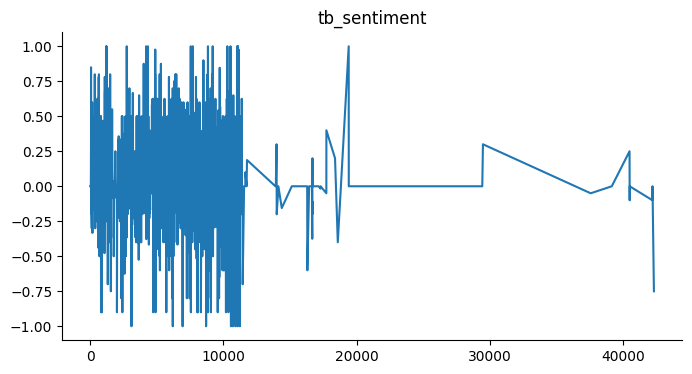

In [93]:
from matplotlib import pyplot as plt
gmes['tb_sentiment'].plot(kind='line', figsize=(8, 4), title='tb_sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

# the sentiment around GME is far more polarised in the later dates in comparison to earlier, with a majority of posts being postive skew in the later dates

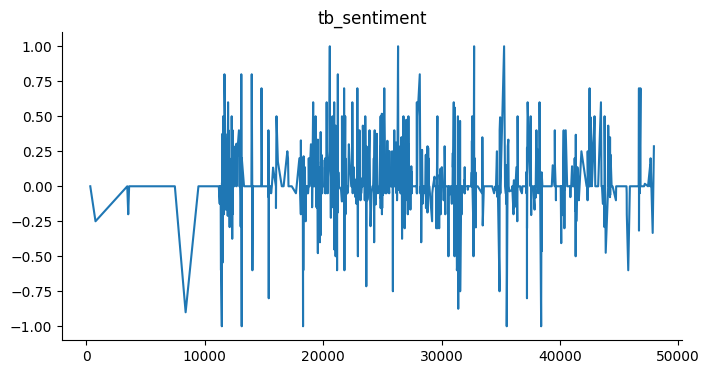

In [94]:
from matplotlib import pyplot as plt
tslas['tb_sentiment'].plot(kind='line', figsize=(8, 4), title='tb_sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

# compared to a more regularly posted stock on the subreddit

# Finding Posts by Stock Ticker

In [18]:
def get_daily_sentiment(dataframe, ticker, sentiment_type='compound'):

    df_ticker = dataframe.copy()[dataframe.orgs.str.contains(ticker)]
    df_ticker_scores = df_ticker.groupby(df_ticker['Date'])[sentiment_type].mean()
    df_ticker_scores = df_ticker_scores.to_frame()
    df_ticker_scores.reset_index(inplace=True)


    return df_ticker_scores

In [19]:
df_tsla_scores = get_daily_sentiment(df,'TSLA',sentiment_type='tb_sentiment')

In [20]:
df_gme_scores = get_daily_sentiment(df,'GME',sentiment_type='tb_sentiment')

# Getting Stock Market Data

In [21]:
pip install yfinance

In [22]:
import yfinance as yf

In [23]:
def get_market_data(ticker, df_scores, min_date,drop_NaN=True):

    ticker = yf.Ticker(ticker)
    min_date = pd.to_datetime(min_date).date()
    max_date = max(df_scores.Date)
    hist = ticker.history(start=min_date, end=max_date)

    hist = hist.reset_index()
    hist['Date'] = hist['Date'].apply(lambda x: x.date())
    hist = hist.set_index("Date")

    df_scores_date = df_scores[df_scores.Date > min_date]
    df_scores_date.set_index('Date', inplace=True, drop=True)

    df_wsb = pd.concat([hist, df_scores_date], axis=1)

    if drop_NaN:
        df_wsb = df_wsb.dropna()

    return df_wsb

In [24]:
df_tsla_wsb = get_market_data('TSLA',df_tsla_scores,'2020-01-01',drop_NaN=False)
df_gme_wsb = get_market_data('GME',df_gme_scores,'2020-01-01',drop_NaN=False)

<Axes: xlabel='Date'>

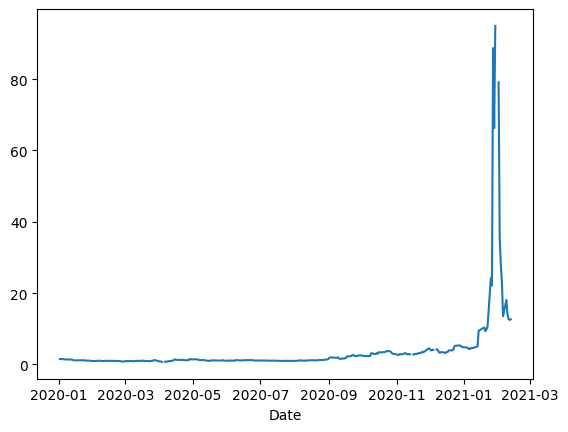

In [104]:
df_gme_wsb['Open'].plot.line()

<Axes: xlabel='Date'>

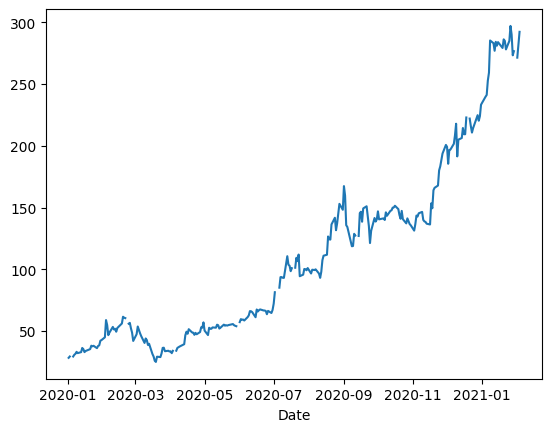

In [105]:
df_tsla_wsb['Open'].plot.line()

In [119]:
## need a visualisation which demonstrates the influence of the stock market value on the sentiment of the posts made the same time

# Post stock data

In [40]:
# i need two values
# 1: the value of the stock at the time of the post
# 2: the value of the stock one week into the time of the post (justified given the majority of these posts are short term options)

# ref: Increase in single stock options volume to open interest ratio indicates much of the volume increase is due to short-term day trading

In [25]:
gmes = gmes.reset_index(drop=True)
gmes.head()

,title,score,removed_by,total_awards_received,created_utc,num_comments,sentiment,compound,tb_sentiment,orgs,Date
0,Is XRT is being used to hide GME shorts?,30,deleted,0.0,1613448160,41,-1,-0.1779,0.0,GME,2021-02-16
1,XRT is being used to hide GME shorts. XRT curr...,219,NaN,7.0,1613443702,434,-1,-0.3147,0.0,GME,2021-02-16
2,is XRT is being used to hide GME shorts?,86,moderator,5.0,1613443199,33,-1,-0.1779,0.0,GME,2021-02-16
3,GME Should Go Bankrupt,36,NaN,2.0,1613441999,804,-1,-0.5574,0.0,GME,2021-02-16
4,"GME holders, don't get discouraged",37,NaN,1.0,1613441772,477,1,0.3089,0.0,GME,2021-02-16


In [26]:
def get_prices(ticker, start, end):
  ticker = yf.Ticker(ticker)
  hist = ticker.history(start=start, end=end)
  hist = hist.reset_index()
  hist['Date'] = hist['Date'].apply(lambda x: x.date())
  hist = hist.set_index("Date")

  return hist[['Open']]

In [ ]:
def get_post_value()

In [28]:
end = gmes['Date'][0]
start = gmes['Date'][len(gmes)-1]

GME_price = get_prices('GME',start, end)
GME_price = GME_price.reset_index()

In [29]:
post_date = gmes['Date'].iloc[2295]

stock_price = GME_price.loc[GME_price['Date'] == post_date]
stock_price

,Date,Open
3,2017-02-28,5.353112


In [172]:
# now write a function to do this for each stock ticker referenced
# this will make it more efficient

## Train Test Split

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

dataset = df_tsla_wsb.values

# Set the X without Open or Date
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) # open price

#X = (dataset[:, 1:6])
#y = (dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## LSTM

In [ ]:
# Create LSTM trained on sentiment analysis data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()



model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train_scale, y_train, epochs = 225, batch_size = 32)

Epoch 1/225
6/6 [==============================] - 6s 21ms/step - loss: 0.0819
Epoch 2/225
6/6 [==============================] - 0s 21ms/step - loss: 0.0348
Epoch 3/225
6/6 [==============================] - 0s 23ms/step - loss: 0.0257
Epoch 4/225
6/6 [==============================] - 0s 25ms/step - loss: 0.0208
Epoch 5/225
6/6 [==============================] - 0s 20ms/step - loss: 0.0152
Epoch 6/225
6/6 [==============================] - 0s 20ms/step - loss: 0.0069
Epoch 7/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 8/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0037
Epoch 9/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0031
Epoch 10/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0022
Epoch 11/225
6/6 [==============================] - 0s 19ms/step - loss: 0.0023
Epoch 12/225
6/6 [==============================] - 0s 20ms/step - loss: 0.0014
Epoch 13/225
6/6 [==============================]

Root mean square error is 0.10469743349792703


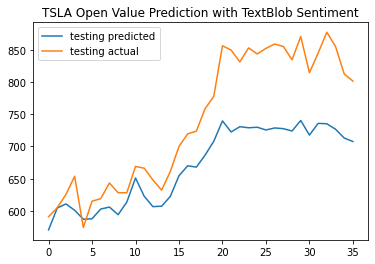

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_stock_tsla = model.predict(X_test_scale)

testScore = np.sqrt(mean_squared_error(y_test[:], predicted_stock_tsla[:,0]))

print('Root mean square error is {}'.format(testScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_tsla),label='testing predicted')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('TSLA Open Value Prediction with TextBlob Sentiment')
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error is 0.015396035409283717


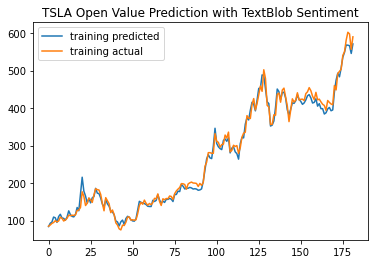

In [ ]:
predicted_stock_tsla_train = model.predict(X_train_scale)

trainScore = np.sqrt(mean_squared_error(y_train[:], predicted_stock_tsla_train[:,0]))

print('Root mean square error is {}'.format(trainScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_tsla_train),label='training predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('TSLA Open Value Prediction with TextBlob Sentiment')
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

## LSTM Without Sentiment Input

In [ ]:
# Test the model without sentiment

# Set the X without Open or Date
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-1])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Create LSTM trained on sentiment analysis data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()



model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train_scale, y_train, epochs = 225, batch_size = 32)

Epoch 1/225
6/6 [==============================] - 6s 18ms/step - loss: 0.0710
Epoch 2/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0381
Epoch 3/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0306
Epoch 4/225
6/6 [==============================] - 0s 17ms/step - loss: 0.0225
Epoch 5/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0180
Epoch 6/225
6/6 [==============================] - 0s 17ms/step - loss: 0.0071
Epoch 7/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 8/225
6/6 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 9/225
6/6 [==============================] - 0s 23ms/step - loss: 0.0019
Epoch 10/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 11/225
6/6 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 12/225
6/6 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 13/225
6/6 [==============================]

Root mean square error is 0.11093801155028846


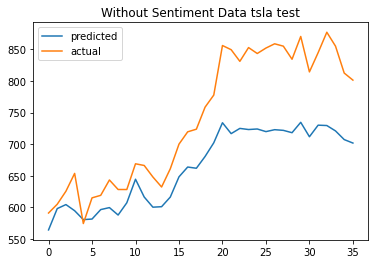

In [ ]:
predicted_stock_tsla = model.predict(X_test_scale)

testScore = np.sqrt(mean_squared_error(y_test[:], predicted_stock_tsla[:,0]))

print('Root mean square error is {}'.format(testScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_tsla),label='predicted')
plt.plot(y_MinMax.inverse_transform(y_test),label='actual')
plt.legend()
plt.title('Without Sentiment Data tsla test')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error is 0.01661466710514053


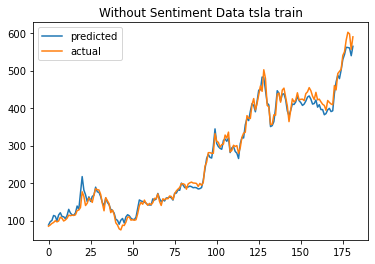

In [ ]:
predicted_stock_tsla_train = model.predict(X_train_scale)

trainScore = np.sqrt(mean_squared_error(y_train[:], predicted_stock_tsla_train[:,0]))

print('Root mean square error is {}'.format(trainScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_tsla_train),label='predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='actual')
plt.legend()
plt.title('Without Sentiment Data tsla train')
plt.show()
plt.clf()
plt.cla()
plt.close()